In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import numpy as np

In [33]:
customers = pd.read_csv('customers.csv')
geolocation = pd.read_csv('geolocation.csv')
order_payments = pd.read_csv('order_payments.csv')
order_reviews = pd.read_csv('order_reviews.csv')
orders = pd.read_csv('orders.csv')
orders_items = pd.read_csv('orders_items.csv')
product_category_name_translation = pd.read_csv('product_category_name_translation.csv')
products = pd.read_csv('products.csv')
sellers = pd.read_csv('sellers.csv')

<ipython-input-33-bda70da7bfa2>:6: DtypeWarning: Columns (1,3,4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  orders_items = pd.read_csv('orders_items.csv')


In [34]:
# Основное объединение таблиц
dataset = (
    orders
    .merge(orders_items, on='order_id', how='inner')
    .merge(products, on='product_id', how='inner')
    .merge(product_category_name_translation, on='product_category_name', how='inner')
    .merge(order_reviews, on='order_id', how='inner')
    .merge(customers, on='customer_id', how='inner')
)

#Рассматриваем только доставленные заказы
dataset = dataset[dataset['order_status'] == 'delivered']

#Количество проданных товаров всех категорий
dataset = pd.merge(
    dataset,
    dataset.groupby('seller_id')['order_id']
    .count()
    .reset_index()
    .rename(columns={'order_id': 'total_orders_per_seller'}),
    on='seller_id',
    how='left'
)

#Статистика продаж товаров по категориям и средняя оценка магазина
dataset = pd.merge(
    dataset,
    dataset.groupby(['product_category_name_english', 'seller_id'])
    .agg(
        total_items_sold_by_category=('order_id', 'count'),
        avg_review_score=('review_score', 'mean'))
    .reset_index()
    .rename(columns={'avg_review_score': 'avg_review_score'}),
    on=['product_category_name_english', 'seller_id'],
    how='left'
)

'''
#На случай, если средняя оценка в seller_stats вносит ошибку

customer_avg_review_score = (
    dataset.groupby('customer_unique_id')['avg_review_score']
    .mean()
    .reset_index()
    .rename(columns={'avg_review_score': 'avg_review_score_unique'})
)

dataset = pd.merge(
    dataset,
    customer_avg_review_score,
    on='customer_unique_id',
    how='left'
)
'''

#Характеристики: Количество купленых категорий у конкретного магазина и по всему маркетплейсу
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['product_category_name_english']
    .count()
    .reset_index()
    .rename(columns={'product_category_name_english': 'customer_bying_prudocts_overoll'}),
    on='customer_unique_id',
    how='left'
)

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'product_category_name_english'])['seller_id']
    .count()
    .reset_index()
    .rename(columns={'seller_id': 'customer_bying_prudocts_by_seller'}),
    on=['customer_unique_id', 'product_category_name_english'],
    how='left'
)

#Перевод данных в формат даты
dataset['order_purchase_month'] = pd.to_datetime(dataset['order_purchase_timestamp']).dt.to_period('M')

dataset = pd.merge(
    dataset,
    dataset.groupby(['customer_unique_id', 'order_purchase_month'])['order_id']
    .count()
    .reset_index(name='monthly_orders'),
    on='customer_unique_id',
    how='left'
)

#Количество всех предметов покупок на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_item_id']
           .count()
           .reset_index()
           .rename(columns={'order_item_id': 'total_items_bought'}),
    on='customer_unique_id',
    how='left'
)

#Количество заказов на покупателя
dataset = pd.merge(
    dataset,
    dataset.groupby('customer_unique_id')['order_id']
    .nunique()
    .reset_index()
    .rename(columns={'order_id': 'number_of_orders'}),
    on='customer_unique_id',
    how='left'
)

In [35]:
# Подготовка датасета: разница между заказами
order_dates = (
    dataset[['customer_unique_id', 'order_purchase_timestamp']]
    .drop_duplicates()
    .sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])
)

# Считаем разницу в днях между заказами
order_dates['order_purchase_timestamp'] = pd.to_datetime(order_dates['order_purchase_timestamp'])
order_dates['days_between'] = (
    order_dates.groupby('customer_unique_id')['order_purchase_timestamp']
    .diff().dt.days
)

# Средняя разница между заказами
avg_days = (
    order_dates.groupby('customer_unique_id')['days_between']
    .mean()
    .reset_index()
    .rename(columns={'days_between': 'avg_days_between_orders'})
)

#Агрегация данных, чтобы избежать поялвений дубликатов customer_unique_id
agg_features = dataset.groupby('customer_unique_id').agg(
    total_items_bought=('total_items_bought', 'max'),
    number_of_orders=('number_of_orders', 'max'),
    customer_bying_prudocts_overoll=('customer_bying_prudocts_overoll', 'max'),
    avg_review_score=('avg_review_score', 'mean')
).reset_index()

features = agg_features[[
    'customer_unique_id',
    'total_items_bought',
    'number_of_orders',
    'customer_bying_prudocts_overoll',
    'avg_review_score'
]].drop_duplicates()

features = features.merge(avg_days, on='customer_unique_id', how='left')
features['avg_days_between_orders'] = features['avg_days_between_orders'].fillna(999)

print(len(features['customer_unique_id']))

def delivery_cluster(days):
    if days <= 60:
        return 0
    elif days <= 120:
        return 1
    else:
        return 2

features['delivery_cluster'] = features['avg_days_between_orders'].apply(delivery_cluster)

features.groupby('delivery_cluster').mean(numeric_only=True)


91482


,total_items_bought,number_of_orders,customer_bying_prudocts_overoll,avg_review_score,avg_days_between_orders
delivery_cluster,,,,,
0,4.206215,2.117938,2.868644,4.077938,14.728046
1,6.498638,2.217984,2.850136,4.104628,88.813579
2,1.173123,1.010892,1.152187,4.104224,993.065881


In [36]:
active_customers = features.loc[features['delivery_cluster'] == 0, 'customer_unique_id']

potentially_go_away_customers = features.loc[features['delivery_cluster'] == 1, 'customer_unique_id']

go_away_customers = features.loc[features['delivery_cluster'] == 2, 'customer_unique_id']

Доступные столбцы в dataset:
['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'Unnamed: 0_x', 'order_item_id', 'product_id', 'seller_id', 'shipping_limit_date', 'price', 'freight_value', 'shipping_limit_date.1', 'price.1', 'freight_value.1', 'product_category_name', 'product_name_lenght', 'product_description_lenght', 'product_photos_qty', 'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm', 'Unnamed: 0_y', 'product_category_name_english', 'Unnamed: 0', 'review_id', 'review_score', 'review_comment_title', 'review_comment_message', 'review_creation_date', 'review_answer_timestamp', 'customer_unique_id', 'customer_zip_code_prefix', 'customer_city', 'customer_state', 'total_orders_per_seller', 'total_items_sold_by_category', 'avg_review_score', 'customer_bying_prudocts_overoll', 'customer_bying_prudocts_by_seller', 'orde

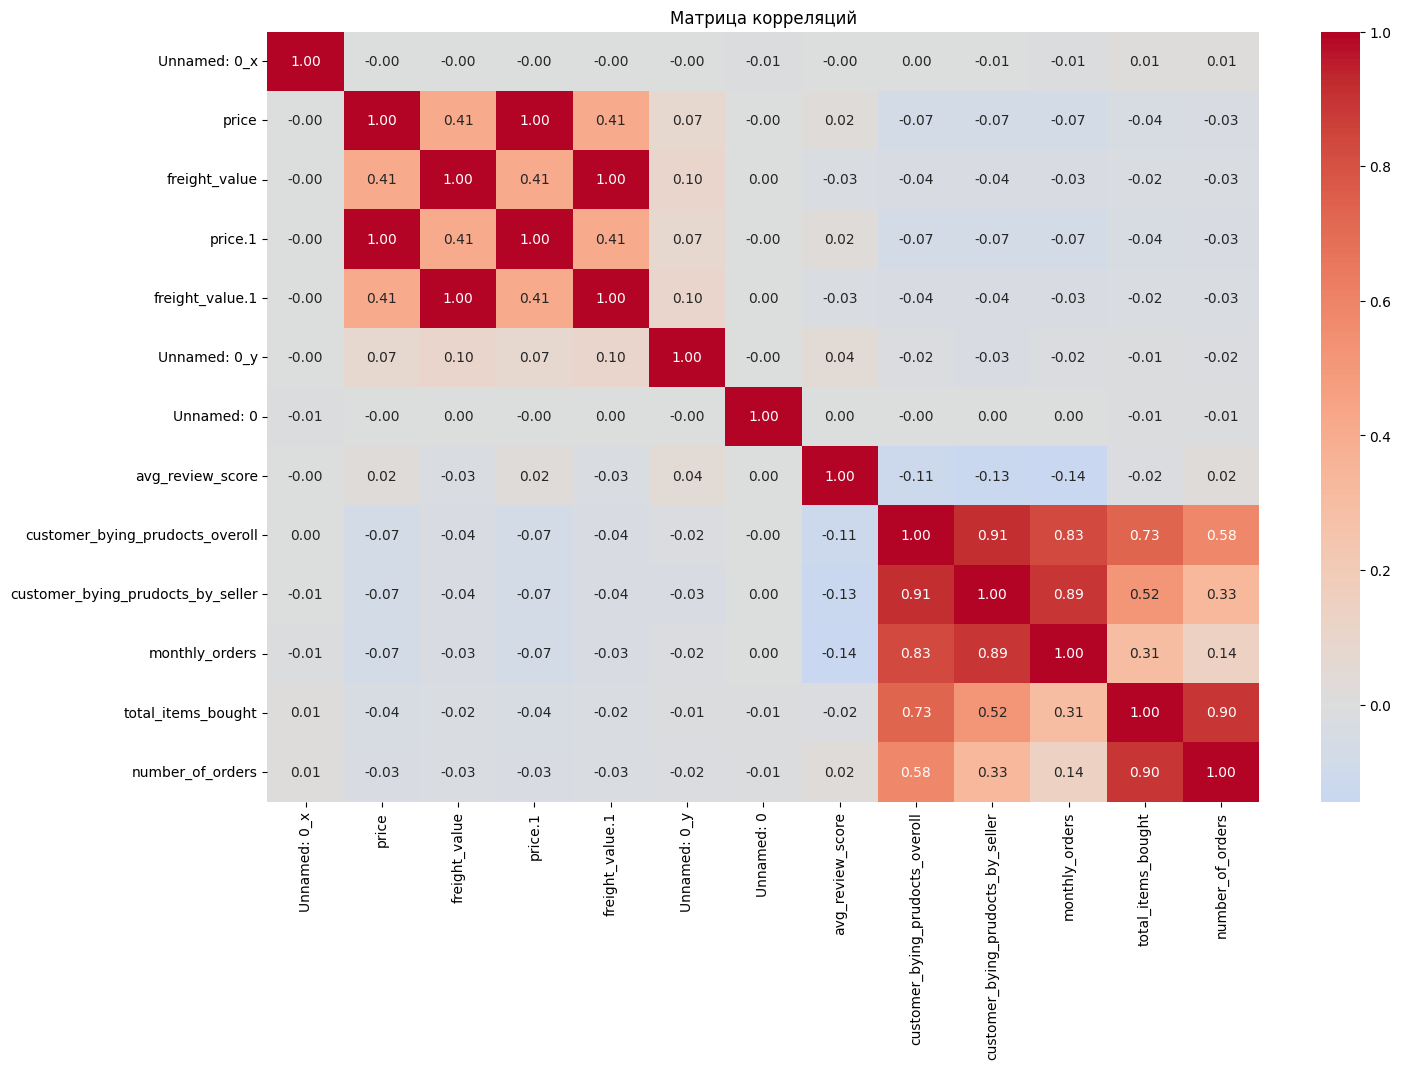

In [37]:
# Сначала посмотрим, какие столбцы есть в dataset
print("Доступные столбцы в dataset:")
print(dataset.columns.tolist())

# Создадим список столбцов для удаления, которые действительно существуют
columns_to_drop = [
    col for col in [
        'id_x', 'order_item_id', 'price_2', 'freight_value_3', 'id_y',
        'review_score', 'customer_zip_code_prefix', 'total_orders_per_seller',
        'total_items_sold_by_category', 'product_name_lenght',
        'product_description_lenght', 'product_photos_qty', 'product_weight_g',
        'product_length_cm', 'product_height_cm', 'product_width_cm'
    ] if col in dataset.columns
]

print("\nСтолбцы, которые будут удалены:")
print(columns_to_drop)

# Удаляем только существующие столбцы
dataset_drop = dataset.drop(columns_to_drop, axis=1)

# Продолжаем анализ
corr_matrix = dataset_drop.corr(numeric_only=True)

plt.figure(figsize=(16, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Матрица корреляций")
plt.show()